In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
import copy


In [8]:
class EVChargeMLPDataset(Dataset):
    def __init__(self, df, target_col='requested_kwh', isTrain=True,
                 input_scaler=None, target_scaler=None):
        self.target_col = target_col

        # 수치형 컬럼 리스트 미리 정의 (필요시 확장)
        numerical_columns = [
            'delivered_kwh', 'kwh_request_diff', 'kwh_per_usage_time'
            # 추가 수치형 변수 필요시 여기에 더 넣으세요!
        ]
        categorical_columns = ['evse_type', 'weekday']

        df = df.copy()
        df.replace({'evse_type': {'': np.nan}}, inplace=True)
        df[numerical_columns] = df[numerical_columns].fillna(0).astype(np.float32)
        df[target_col] = df[target_col].fillna(0).astype(np.float32)

        # 원핫 인코딩
        df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
        one_hot_columns = [col for col in df.columns 
                           if any([col.startswith(f"{cat}_") for cat in categorical_columns])]
        df[one_hot_columns] = df[one_hot_columns].fillna(0).astype(np.float32)

        self.numerical_columns = numerical_columns
        self.one_hot_columns = one_hot_columns
        self.input_columns = numerical_columns + one_hot_columns

        # 스케일링
        if isTrain:
            df[numerical_columns] = input_scaler.fit_transform(df[numerical_columns])
            df[[target_col]] = target_scaler.fit_transform(df[[target_col]])
            joblib.dump(input_scaler, "../model/input_scaler.pkl")
            joblib.dump(target_scaler, "../model/target_scaler.pkl")
            joblib.dump(self.input_columns, "../model/expected_features.pkl")
            joblib.dump(self.one_hot_columns, "../model/one_hot_columns.pkl")
        else:
            df[numerical_columns] = input_scaler.transform(df[numerical_columns])
            df[[target_col]] = target_scaler.transform(df[[target_col]])

        self.x = torch.tensor(df[self.input_columns].values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [9]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout=0.1):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, output_size)
        )

    def forward(self, x):
        return self.model(x)


[1/100] Train Loss: 0.0127 / Val Loss: 0.0033
[2/100] Train Loss: 0.0050 / Val Loss: 0.0048
[3/100] Train Loss: 0.0043 / Val Loss: 0.0065
[4/100] Train Loss: 0.0040 / Val Loss: 0.0055
[5/100] Train Loss: 0.0037 / Val Loss: 0.0059
[6/100] Train Loss: 0.0035 / Val Loss: 0.0110
[7/100] Train Loss: 0.0034 / Val Loss: 0.0096
[8/100] Train Loss: 0.0031 / Val Loss: 0.0102
[9/100] Train Loss: 0.0031 / Val Loss: 0.0114
[10/100] Train Loss: 0.0030 / Val Loss: 0.0119
[11/100] Train Loss: 0.0030 / Val Loss: 0.0116
✅ 조기 종료: 11 epoch
MAE: 0.411
RMSE: 0.521
R^2: 0.997


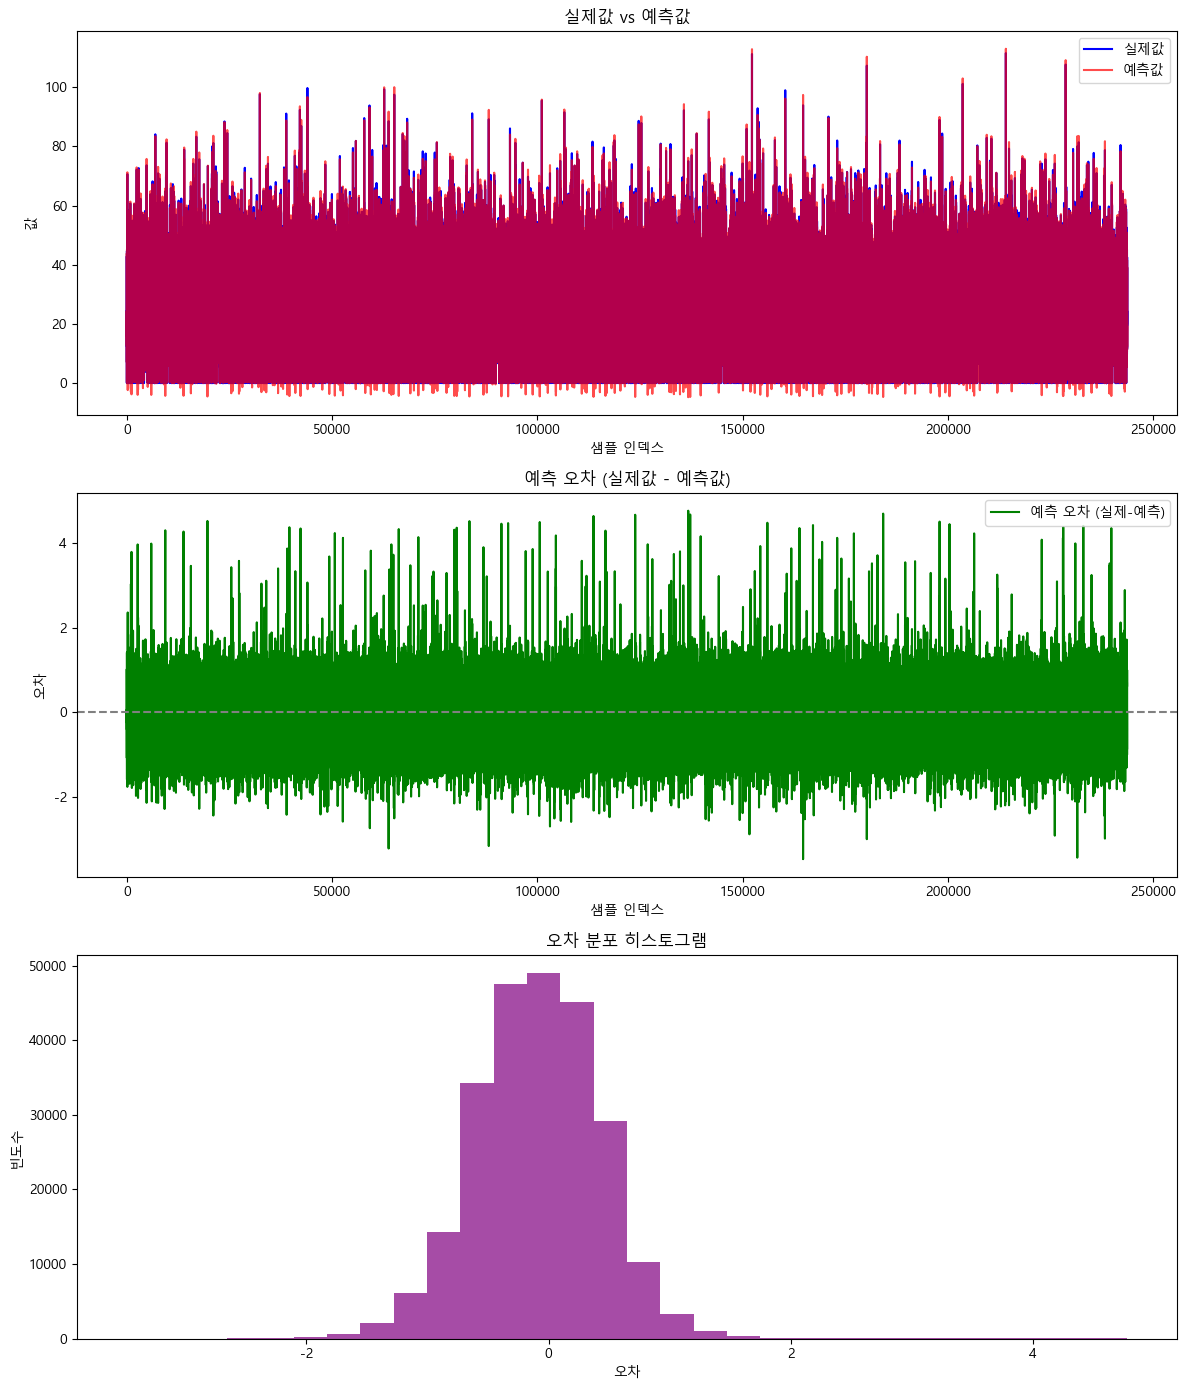

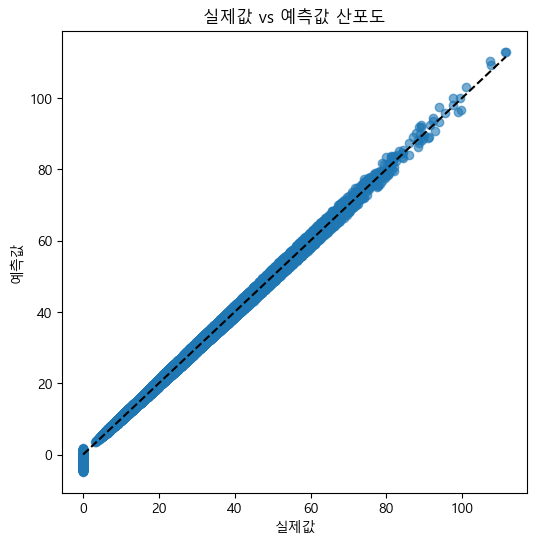

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import copy


plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (12, 6)

# 데이터 준비
df = pd.read_csv('../data/50area_dummy_processed.csv')
input_scaler = StandardScaler()
target_scaler = StandardScaler()
target_col = 'requested_kwh'

train_dataset = EVChargeMLPDataset(
    df, target_col=target_col, isTrain=True, 
    input_scaler=input_scaler, target_scaler=target_scaler
)
test_dataset = EVChargeMLPDataset(
    df, target_col=target_col, isTrain=False, 
    input_scaler=input_scaler, target_scaler=target_scaler
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_size = len(train_dataset.input_columns)
mlp_model = MLPModel(input_size=input_size).to("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')
patience = 10
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(100):
    mlp_model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = mlp_model(batch_x).squeeze(-1)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    mlp_model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in test_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            output = mlp_model(val_x).squeeze(-1)
            loss = criterion(output, val_y)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    scheduler.step(val_loss)

    print(f"[{epoch+1}/100] Train Loss: {train_loss:.4f} / Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(mlp_model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"✅ 조기 종료: {epoch+1} epoch")
            break

torch.save(best_model, "../model/mlp_model_best.pth")

#  --- 여기부터 결과 분석 및 시각화 코드 추가 ---

# 1. 베스트 모델 불러오기
mlp_model.load_state_dict(best_model)
mlp_model.eval()

# 2. 예측 수행
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = mlp_model(batch_x).squeeze(-1).cpu().numpy()
        targ = batch_y.cpu().numpy()
        all_preds.append(pred)
        all_targets.append(targ)

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# 3. 정규화 → 역변환
all_preds_rescaled = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).reshape(-1)
all_targets_rescaled = target_scaler.inverse_transform(all_targets.reshape(-1, 1)).reshape(-1)

# 4. 주요 평가지표 출력
def print_error_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")

print_error_metrics(all_targets_rescaled, all_preds_rescaled)

# 5. 예측 결과 시각화 함수 (그래프 3종)
def plot_prediction_results(y_true, y_pred):
    n = len(y_true)
    indices = np.arange(n)
    errors = y_true - y_pred

    fig, axs = plt.subplots(3, 1, figsize=(12, 14))

    axs[0].plot(indices, y_true, label='실제값', color='blue')
    axs[0].plot(indices, y_pred, label='예측값', color='red', alpha=0.7)
    axs[0].set_title('실제값 vs 예측값')
    axs[0].set_xlabel('샘플 인덱스')
    axs[0].set_ylabel('값')
    axs[0].legend()

    axs[1].plot(indices, errors, label='예측 오차 (실제-예측)', color='green')
    axs[1].axhline(0, color='gray', linestyle='--')
    axs[1].set_title('예측 오차 (실제값 - 예측값)')
    axs[1].set_xlabel('샘플 인덱스')
    axs[1].set_ylabel('오차')
    axs[1].legend()

    axs[2].hist(errors, bins=30, color='purple', alpha=0.7)
    axs[2].set_title('오차 분포 히스토그램')
    axs[2].set_xlabel('오차')
    axs[2].set_ylabel('빈도수')

    plt.tight_layout()
    plt.show()

def plot_scatter(y_true, y_pred):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='black', linestyle='--')
    plt.xlabel('실제값')
    plt.ylabel('예측값')
    plt.title('실제값 vs 예측값 산포도')
    plt.show()

# 그래프 호출
plot_prediction_results(all_targets_rescaled, all_preds_rescaled)
plot_scatter(all_targets_rescaled, all_preds_rescaled)
